In [1]:
%matplotlib inline
from solveSym import linearSolve_krylov as linearSolve
import numpy as np, matplotlib.pyplot as plt
import pystokes

In [2]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

In [3]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## squirmer
D0  = 1.0      
S0  = 3/50*D0    # beta = 1 (positive beta is a puller (negative V2s)) - not sure which sign!

In [4]:
## initialise 
#initial position
r = np.array([-1.5,1.5, 0.,0. , 0., 0.])

#initial orientation
p = np.array([0., 0., 0.,0., 1.,1.])

##rotate particles 50deg towards each other
p[::Np] = rotation(p[::Np], 0., 25*2*np.pi/360, 0.)
p[1::Np] = rotation(p[1::Np], 0., -25*2*np.pi/360, 0.)


# initial slip modes
S = np.zeros(5*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yx, yy, yz, zx, zy, zz
    S[i]       = S0*(3*p[i]*p[i] -1.)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np] - 1.)
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

In [5]:
def rhs(rp): ##change this to give polarisation directly
    """
    Function that gives rhs for equations dr/dt=v and dp/dt= o x p
    """
    
    #position and angle theta (relative to initial angle)
    r = rp[0:3*Np]; p = rp[3*Np:6*Np]
    
    ## make sure orientations remain unit length
    norm_p1 = np.dot(p[::Np],p[::Np])
    norm_p2 = np.dot(p[1::Np],p[1::Np])
    
    p[::Np] = p[::Np]/np.sqrt(norm_p1)
    p[1::Np] = p[1::Np]/np.sqrt(norm_p2)
    
    
    F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
    
    for i in range(Np):          
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0 
        
        T[i]      = 0.0
        T[i+Np]   = 0.0
        T[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
        
        S[i]       = S0*(3*p[i]*p[i] -1.)
        S[i + Np]  = S0*(3*p[i]*p[i+Np])
        S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
        S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np] - 1.)
        S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
        
        D[i]       = D0*p[i]
        D[i+Np]    = D0*p[i+Np]
        D[i+2*Np]  = D0*p[i+2*Np]

    
    #update repulsive force at position r
    forces.lennardJones(F, r, lje=5.0, ljr=2.1*b)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    ls.RBM(v, o, r, F, T, S, D)
    
    dpdt = np.zeros(3*Np)
    
    for i in range(Np):
        dpdt[i]      = o[i+Np]*p[i+2*Np] - o[i+2*Np]*p[i+Np]    
        dpdt[i+Np]   = o[i+2*Np]*p[i   ] - o[i     ]*p[i+2*Np]  
        dpdt[i+2*Np] = o[i     ]*p[i+Np] - o[i+Np  ]*p[i]
        

    
    #return velocity and angular velocity cross orientation as right-hand side
    return np.concatenate( (v,dpdt) )

In [6]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=None, **kwargs)
        
    return X

In [7]:
%%time
#initiallize system and forces
ls = linearSolve(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 500.
Npts = 10

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1000,
             method='BDF')
X.message

CPU times: user 1min 7s, sys: 105 ms, total: 1min 7s
Wall time: 45.3 s


'The solver successfully reached the end of the integration interval.'

In [8]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [9]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

In [10]:
plt.rcParams.update({'font.size': 17})

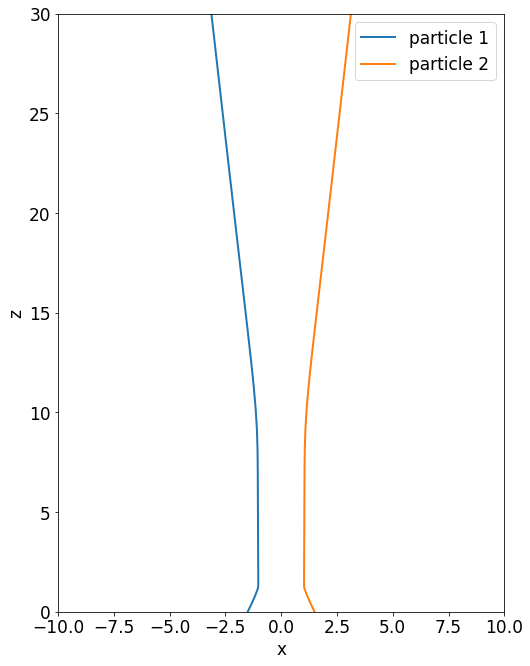

In [11]:
##x-y plot like in Ishikawa
plt.figure(figsize=(8,11))
plt.plot(pos1[:,0], pos1[:,2], label='particle 1', lw=2)
plt.plot(pos2[:,0], pos2[:,2], label='particle 2', lw=2)
plt.xlabel('x')
plt.ylabel('z')
plt.ylim(0,30)
plt.xlim(-10,10)
plt.legend()
plt.show()

In [12]:
## minimum distance between the two particles
rmin = np.amin(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmax = np.amax(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmin, rmax

(2.0501026091577073, 20.018785864714502)

In [13]:
minIndex = np.where(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2)==rmin)
#minIndex[0][0] -= 18
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
minIndex

(array([17]),)

In [14]:
xik,yik,zik ##they go out of plane? not anymore! 

(-2.0501026091577073, 2.49525622396766e-10, 1.8649415345350917e-10)

In [15]:
##why does Krylov solver go so wrong? seems to introduce numerical error. 

## Try symmetry factor corrected matrix elements with a direct solver? 

In [16]:
print(pos1[:,0] + pos2[:,0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  8.88178420e-16  1.04360964e-14  1.73194792e-14
 -1.14797061e-13 -1.32560629e-11 -2.50492960e-11 -3.06408232e-11
 -6.07307538e-10 -9.02720787e-10 -1.00415631e-09 -4.15648826e-09
 -6.27697383e-09 -1.15270424e-08 -1.55223081e-08 -1.93901508e-08
 -4.12203509e-08 -5.04330246e-08 -4.47452559e-08 -4.03208367e-08
 -4.20967510e-08 -5.88291338e-08 -8.97131178e-08 -1.43403244e-07
 -2.20120167e-07 -2.78909586e-07 -4.21803372e-07 -9.12648267e-07
 -1.38605091e-06 -1.51472159e-06 -1.44834050e-06 -1.35064759e-06
 -1.20403903e-06 -1.07938640e-06 -9.63112173e-07 -7.24564399e-07
 -4.75588313e-07 -2.18158803e-07  4.01985791e-08  3.96565250e-07
  7.53005282e-07  1.11059482e-06  1.81617011e-06  2.52175601e-06
  3.22332433e-06  3.92227969e-06  4.18364457e-06]


In [17]:
orientations = X.y.T[:,3*Np:6*Np]
or1 = orientations[:,::Np]
or2 = orientations[:,1::Np]

In [18]:
or1[:,0] + or2[:,0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.11022302e-16,  1.49880108e-15,  1.01030295e-14,  1.75415238e-14,
        8.66695604e-13,  1.03916875e-13, -6.83508805e-13, -2.73758793e-12,
       -2.41962006e-11, -3.57598950e-11, -3.95586341e-11, -2.22425744e-10,
       -4.58621641e-10, -1.09746137e-09, -1.20876584e-09, -1.05387585e-09,
       -1.50542148e-09, -3.73534192e-09, -6.25514441e-09, -8.37941595e-09,
       -1.04826204e-08, -1.75423650e-08, -2.80451770e-08, -3.66685699e-08,
       -4.13058319e-08, -4.09171395e-08, -3.25539425e-08,  7.52013229e-09,
        4.95145225e-08,  6.56904015e-08,  6.64604563e-08,  6.42370811e-08,
        6.30895567e-08,  6.31688982e-08,  6.37090121e-08,  6.52397255e-08,
        6.60537159e-08,  6.62890779e-08,  6.64135869e-08,  6.66810170e-08,
        6.69510283e-08,  6.71719295e-08,  6.71909243e-08,  6.68907997e-08,
        6.66519992e-08,  

In [19]:
or1[:,2] - or2[:,2]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.11022302e-16,
        2.22044605e-16,  3.33066907e-16, -7.77156117e-15, -8.32667268e-15,
       -5.67990099e-13, -2.26807462e-12,  3.51163543e-13,  1.04261044e-12,
        9.16788867e-12,  1.11847198e-11,  1.40175649e-11,  2.67235234e-10,
        3.83898469e-10, -7.48257900e-10, -1.04510400e-09, -1.81329074e-09,
        2.68039402e-09,  2.04196926e-09,  1.56922997e-09, -2.07981632e-10,
        1.31813116e-10, -1.22808763e-09, -2.81669121e-09, -4.81350870e-09,
       -5.69941705e-09, -5.63145153e-09, -4.49560611e-09,  8.54880722e-10,
        6.54088805e-09,  8.50702520e-09,  8.42559611e-09,  7.97653987e-09,
        7.57602003e-09,  7.35517869e-09,  7.24661209e-09,  7.18676496e-09,
        7.12401216e-09,  7.02980263e-09,  6.95518454e-09,  6.90314583e-09,
        6.87719137e-09,  6.86235890e-09,  6.83602086e-09,  6.76823231e-09,
        6.70375266e-09,  

In [20]:
X.nfev

143